---
### CIS 575 Project
### Mateo Forero
---

Import all necessary libraries

In [89]:
# Data exploration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate
# Missing value imputation
import miceforest as mf 
# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
# Model Metrics
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
# Feature Importance
from sklearn.inspection import PartialDependenceDisplay

# Processing Data

First step is to load the data set we are planning to use and investigate some of its properties. Additionally the ID column is being dropped and the natural index of the tibble will be used. The decision is being made to only work with adults. The data set has 856 cases where the patient is below the age of 18 and of those cases only 2 have had a stroke (0.23%). The rate of stroke in children is much lower than those in adults (estimated as 4.6 per 100,000 children), and is commonly associated with risk factors not captured in this data set (e.g genetic conditions). This will allow for a more focused study.  


In [3]:
raw_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
raw_data.drop('id',axis = 1,inplace = True)
adult_data = raw_data[raw_data['age'] >= 18]

In [4]:
adult_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
adult_data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
adult_data.describe(include= 'all')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4254,4254.000000,4254.000000,4254.000000,4254,4254,4254,4254.000000,4073.000000,4254,4254.000000
unique,3,NaN,NaN,NaN,2,4,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2576,NaN,NaN,NaN,3353,2791,2169,NaN,NaN,1752,NaN
mean,NaN,50.202163,0.116831,0.064645,NaN,NaN,NaN,108.514394,30.432752,NaN,0.058063
std,NaN,17.829035,0.321257,0.245927,NaN,NaN,NaN,47.769400,7.235143,NaN,0.233890
min,NaN,18.000000,0.000000,0.000000,NaN,NaN,NaN,55.120000,11.300000,NaN,0.000000
25%,NaN,36.000000,0.000000,0.000000,NaN,NaN,NaN,77.482500,25.400000,NaN,0.000000
50%,NaN,50.500000,0.000000,0.000000,NaN,NaN,NaN,92.465000,29.200000,NaN,0.000000
75%,NaN,64.000000,0.000000,0.000000,NaN,NaN,NaN,116.135000,34.200000,NaN,0.000000


In [7]:
adult_data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  181
smoking_status         0
stroke                 0
dtype: int64

Quick summary of stats show: 11.7% have hypertension, 6.46% have heart disease, and the response variable is only positive for 5.81% of the data. The average glucose level has a positive skew causing the mean to be larger than our median.

Our only numeric column with missing values is BMI. Approximately 4.25% of the cases are missing BMI values. Additionally we have 1 'Other' under gender and 862 'Unknown' under smoking_status. To simplify the model we will assume gender is categorizing biological sex and will assign the "Other" to Female which is the most common gender in our data set. I'll treat the 'Unknown' as a valid category of smoking_status. Under work_type we have 5 'Never_worked' which comprises of 0.12% of the total cases so they will be changed to Private. These were more prevalent when children were still being considered in our model.   

We will be utilizing cross-validation, and imputation of BMI will be applied for each fold to prevent data leakage. Data leakage is assumed to be negligible for the Gender and Work Type variable changes since they constitute such a small number of cases changed. 


In [8]:
adult_data.loc[adult_data.gender == "Other",'gender'] = "Female"
adult_data.loc[adult_data.work_type == "Never_worked",'work_type'] = "Private"

C:\Users\spidy\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


# Visualizing the data
We will break our data into groups we care to analyze further with graphs

In [9]:
ht_data = adult_data.loc[adult_data.hypertension == 1,:].groupby('gender')['stroke'].value_counts(normalize = True)
ht_data = ht_data.mul(100).rename('Percent').reset_index()
ht_data.rename(columns={"level_1": "stroke"},inplace=True)

no_ht_data = adult_data.loc[adult_data.hypertension == 0,:].groupby('gender')['stroke'].value_counts(normalize = True)
no_ht_data = no_ht_data.mul(100).rename('Percent').reset_index()
no_ht_data.rename(columns={"level_1": "stroke"},inplace=True)

hd_data = adult_data.loc[adult_data.heart_disease == 1,:].groupby('gender')['stroke'].value_counts(normalize = True)
hd_data = hd_data.mul(100).rename('Percent').reset_index()
hd_data.rename(columns={"level_1": "stroke"},inplace=True)

no_hd_data = adult_data.loc[adult_data.heart_disease == 0,:].groupby('gender')['stroke'].value_counts(normalize = True)
no_hd_data = no_hd_data.mul(100).rename('Percent').reset_index()
no_hd_data.rename(columns={"level_1": "stroke"},inplace=True)

The first set of graphs will investigate how big of an influence hypertension is on having a stroke. Because only 11.7% of the cases have hypertension we will graph these separately. We also separate genders to see if there is a major difference. This same exercise will be performed on heart disease.

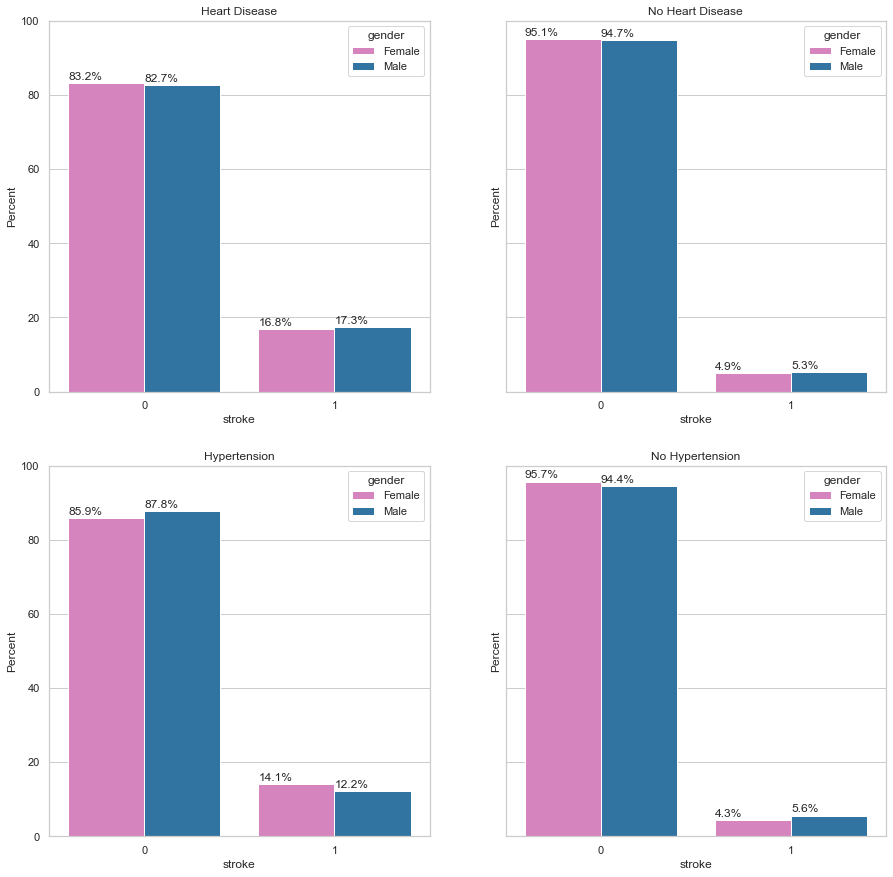

In [10]:
sns.set_theme(style="whitegrid")
palette = {
    'Male': 'tab:blue',
    'Female': 'tab:pink'}
fig, axes = plt.subplots(2, 2, figsize = (15, 15), sharey = True)

# Heart Disease Plot
hd_plot = sns.barplot(ax = axes[0,0], x = 'stroke', y = 'Percent',
                      hue = 'gender', palette = palette, data = hd_data)
hd_plot.axes.set_ylim(0,100)
hd_plot.set_title("Heart Disease")

for p in hd_plot.axes.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 1
    hd_plot.axes.text(txt_x,txt_y,txt)

# No Heart Disease Plot
no_hd_plot = sns.barplot(ax = axes[0,1], x = 'stroke', y = 'Percent',
                         hue = 'gender', palette = palette, data = no_hd_data)
no_hd_plot.axes.set_ylim(0,100)
no_hd_plot.set_title("No Heart Disease")

for p in no_hd_plot.axes.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 1
    no_hd_plot.axes.text(txt_x,txt_y,txt)

    
# Hypertension Plot
ht_plot = sns.barplot(ax = axes[1,0], x = 'stroke', y = 'Percent',
                      hue = 'gender', palette = palette, data = ht_data)
ht_plot.axes.set_ylim(0,100)
ht_plot.set_title("Hypertension")

for p in ht_plot.axes.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 1
    ht_plot.axes.text(txt_x,txt_y,txt)

# No Hypertension Plot
no_ht_plot = sns.barplot(ax = axes[1,1], x = 'stroke', y = 'Percent',
                         hue = 'gender', palette = palette, data = no_ht_data)
no_ht_plot.axes.set_ylim(0,100)
no_ht_plot.set_title("No Hypertension")

for p in no_ht_plot.axes.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 1
    no_ht_plot.axes.text(txt_x,txt_y,txt)
    

Text(0, 0.5, 'Log Scaled BMI')

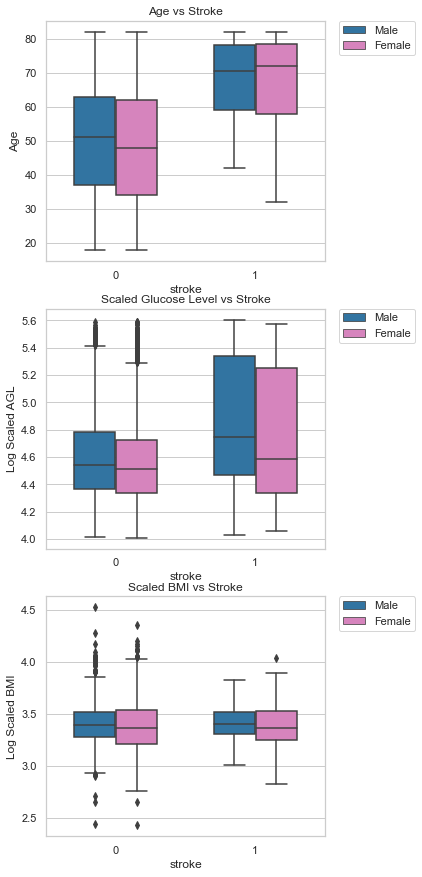

In [11]:
fig, axes = plt.subplots(3, 1, figsize = (5, 15))

# Age Boxplot
age_boxplot = sns.boxplot(ax = axes[0], x = 'stroke', y = 'age',
                          hue = 'gender', data= adult_data ,
                          palette= palette, width = 0.6)
age_boxplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
age_boxplot.axes.set_title("Age vs Stroke")
age_boxplot.axes.set_ylabel("Age")

# Scaled AGL Boxplot
agl_boxplot = sns.boxplot(ax = axes[1], x = 'stroke', y = np.log(adult_data.avg_glucose_level),
                          hue = 'gender', data= adult_data ,
                          palette= palette, width = 0.6)
agl_boxplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
agl_boxplot.axes.set_title("Scaled Glucose Level vs Stroke")
agl_boxplot.axes.set_ylabel("Log Scaled AGL")

# Scaled BMI Boxplot
bmi_boxplot = sns.boxplot(ax = axes[2], x = 'stroke', y = np.log(adult_data.bmi),
                          hue = 'gender', data= adult_data ,
                          palette= palette, width = 0.6)
bmi_boxplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
bmi_boxplot.axes.set_title("Scaled BMI vs Stroke")
bmi_boxplot.axes.set_ylabel("Log Scaled BMI")

Next we will look at whether we see a difference in the categorical values and their average rate of stroke.

In [12]:
pie_res_type = adult_data.groupby('Residence_type').mean()
pie_res_type['stroke_proportion'] = 100*round(pie_res_type['stroke'] / pie_res_type['stroke'].sum(),3)

pie_work_type = adult_data.groupby('work_type').mean()
pie_work_type['stroke_proportion'] = 100*round(pie_work_type['stroke'] / pie_work_type['stroke'].sum(),3)

pie_smoke_type = adult_data.groupby('smoking_status').mean()
pie_smoke_type['stroke_proportion'] = 100*round(pie_smoke_type['stroke'] / pie_smoke_type['stroke'].sum(),3)

pie_married_type = adult_data.groupby('ever_married').mean()
pie_married_type['stroke_proportion'] = 100*round(pie_married_type['stroke'] / pie_married_type['stroke'].sum(),3)

Text(0, 0.5, '')

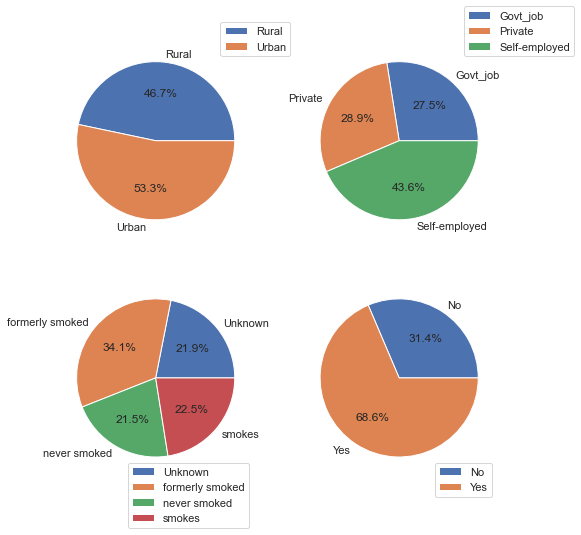

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8))

res_pie = pie_res_type.plot(kind = 'pie', y = 'stroke_proportion',
                  ax = axes[0,0], autopct = '%.1f%%', legend = False)
res_pie.legend(bbox_to_anchor=(.8, .9))
res_pie.set_ylabel("")

work_pie = pie_work_type.plot(kind = 'pie', y = 'stroke_proportion',
                  ax = axes[0,1], autopct = '%.1f%%')
work_pie.legend(bbox_to_anchor=(.8, .9))
work_pie.set_ylabel("")

smoke_pie = pie_smoke_type.plot(kind = 'pie', y = 'stroke_proportion',
                  ax = axes[1,0], autopct = '%.1f%%')
smoke_pie.legend(bbox_to_anchor=(1, .1))
smoke_pie.set_ylabel("")

married_pie = pie_married_type.plot(kind = 'pie', y = 'stroke_proportion',
                  ax = axes[1,1], autopct = '%.1f%%')
married_pie.legend(bbox_to_anchor=(1, .1))
married_pie.set_ylabel("")

# Model Pre-Processing

As this point we have all the visual inference about our data and how it relates to the response variable. Although we will tune our models individually, to write efficient code we will automate our data pre-processing so we can train and test our models with ease. 

I chose to impute our missing BMI values using a random forest imputation method. This method performs very well when the variable being imputed is normally distributed. All the binary variables will be converted to categorical. Imputation will be used against all the null values in the dataset later.

C:\Users\spidy\anaconda3\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


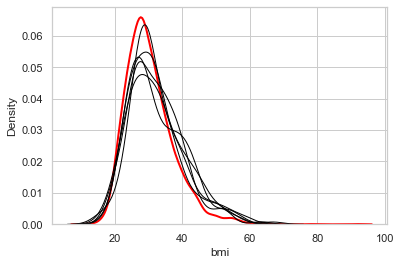

In [14]:
# Change object and binary to categorical types
obj_cat = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']
adult_data.loc[:,obj_cat] = adult_data.loc[:,obj_cat].astype('category')

# Create kernel. 
mice_result = mf.ImputationKernel(
  adult_data,
  datasets=5,
  save_all_iterations=True,
  random_state=575
)

# Run the MICE algorithm for 3 iterations on each of the datasets
mice_result.mice(3)
mice_result.plot_imputed_distributions()
complete_data = mice_result.complete_data(0)

I'll now create dummy variables to represent the categorical data to preform a smote procedure later in our cross validation. Additionally the data will be split 85/15 used stratified indexing to have a test set to determine final model potential. In the R implementation of the Logistic Model, some category combinations were performed after seing partial levels dropped. To avoid dropping partial levels, the same combinations will be done here

In [15]:
complete_data['work_type'] = np.where((complete_data['work_type'] == "Govt_job") | (complete_data['work_type'] == "Private"),
         "GP", "SE")
complete_data['smoking_status'] = np.where((complete_data['smoking_status'] == "formerly smoked") | (complete_data['smoking_status'] == "smokes"),
         "smoked", complete_data['smoking_status'])
complete_data['smoking_status'] = np.where(complete_data['smoking_status'] == "never smoked",
                                           "never_smoked", complete_data['smoking_status'])

dum_col = ["gender","hypertension", "heart_disease",
           "ever_married", "work_type", "Residence_type",
           "smoking_status"]
dummy_data = pd.get_dummies(complete_data, columns = dum_col, drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(dummy_data.drop('stroke',axis = 1),
                                                    dummy_data['stroke'],
                                                    test_size = 0.15, stratify = dummy_data['stroke'], random_state = 575)

In [16]:
# This data will  be used to tune the hyperparameters of the Random Forest Classifier and the Gradient Boosted Classifier
X_resampled_hyp, y_resampled_hyp = SMOTE(random_state= 575).fit_resample(X_train, y_train)

In [17]:
# This function will be used to determine which fold has the best F-score when threshold is optimized. 
# A seperate version was written because the logistic model was not from sklearn so the model has different arguments
def Fb_thresh(x_test,y_test,model, Beta = 2):
    prob_true = model.predict_proba(x_test)[:,1]
    observed = y_test
    
    temp_df = pd.DataFrame(columns=['prob','labeled'],
                           index = range(len(prob_true)))
    temp_df['prob'] = prob_true
    
    thrs = np.linspace(0.05,0.95,  num = 100)
    thrs_f_table = pd.DataFrame(columns=['threshold', 'F-Beta_Score'],
                                index = range(len(thrs)))
    
    
    for i in range(len(thrs)):
        temp_df['labeled'] = temp_df['prob'].apply(lambda x : 1 if x > thrs[i] else 0)
        thrs_f_table['F-Beta_Score'][i] =  fbeta_score(observed, temp_df['labeled'], beta = Beta)
        thrs_f_table['threshold'][i] = thrs[i]
    
    thrs_f_table['F-Beta_Score'].fillna(0,inplace= True)
    max_thres = thrs_f_table[thrs_f_table['F-Beta_Score'] == thrs_f_table['F-Beta_Score'].max()]
    max_thres.reset_index(drop=True, inplace=True)
    return(max_thres)

def Fb_thresh_log(x_test,y_test,model, Beta = 2):
    results = model.fit()
    prob_true = model.predict(params = results.params, exog =  x_test)
    observed = y_test
    
    temp_df = pd.DataFrame(columns=['prob','labeled'],
                           index = range(len(prob_true)))
    temp_df['prob'] = prob_true
    
    thrs = np.linspace(0.05,0.95,  num = 100)
    thrs_f_table = pd.DataFrame(columns=['threshold', 'F-Beta_Score'],
                                index = range(len(thrs)))
    
    
    for i in range(len(thrs)):
        temp_df['labeled'] = temp_df['prob'].apply(lambda x : 1 if x > thrs[i] else 0)
        thrs_f_table['F-Beta_Score'][i] =  fbeta_score(observed, temp_df['labeled'], beta = Beta)
        thrs_f_table['threshold'][i] = thrs[i]
    
    thrs_f_table['F-Beta_Score'].fillna(0,inplace= True)
    max_thres = thrs_f_table[thrs_f_table['F-Beta_Score'] == thrs_f_table['F-Beta_Score'].max()]
    max_thres.reset_index(drop=True, inplace=True)
    return(max_thres)


## Model 1: Logistic Regression
Logistic Regression. An step AIC optimization algorithm was used in the R script to determine the best parameters to use 

In [20]:
kf = StratifiedKFold(n_splits = 10, shuffle= True, random_state = 575)
log_col = ['intercept','age', 'avg_glucose_level', 'hypertension_1',
        'heart_disease_1', 'work_type_SE', 'Residence_type_Urban',
        'smoking_status_never_smoked', 'smoking_status_smoked']
log_x_train = X_train.copy()
log_x_train['intercept'] = 1
log_x_train.reset_index(drop=True, inplace=True)
fold = 1

Log_CV_Results = pd.DataFrame(columns=['Fold', 'Threshold', 'F-2_Score'], index = range(10))

for train_index, test_index in kf.split(log_x_train,y_train):
    X_train_cv = log_x_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    X_test_cv = log_x_train.iloc[test_index]
    y_test_cv = y_train.iloc[test_index]
    X_resampled, y_resampled = SMOTE(random_state= 575).fit_resample(X_train_cv, y_train_cv)
    
    logit_model = sm.GLM(y_resampled, X_resampled[log_col], family=sm.families.Binomial())
    temp_df = Fb_thresh_log(X_test_cv[log_col],y_test_cv, logit_model, Beta = 2)
    
    
    Log_CV_Results['Fold'][fold-1] = fold
    Log_CV_Results['Threshold'][fold-1] = round(temp_df['threshold'][0],4)
    Log_CV_Results['F-2_Score'][fold-1] = round(temp_df['F-Beta_Score'][0],4)
    fold += 1
    
Log_CV_Results

,Fold,Threshold,F-2_Score
0,1,0.3682,0.3846
1,2,0.3227,0.3488
2,3,0.2045,0.3617
3,4,0.3045,0.3415
4,5,0.2227,0.4032
5,6,0.3318,0.3483
6,7,0.5864,0.4027
7,8,0.2409,0.3097
8,9,0.5864,0.4717
9,10,0.2864,0.3556


## Model 2: Random Forest Classifier.  



In [21]:
rf = RandomForestClassifier(random_state=575)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2,
                               random_state=575, n_jobs = -1,scoring='f1')# Fit the random search model

rf_random.fit(X_train,y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [22]:
RF_CV_Results = pd.DataFrame(columns=['Fold', 'Threshold', 'F-2_Score'], index = range(10))
fold = 1
for train_index, test_index in kf.split(X_train,y_train):
    X_train_cv = X_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    X_test_cv = X_train.iloc[test_index]
    y_test_cv = y_train.iloc[test_index]
    X_resampled, y_resampled = SMOTE(random_state= 575).fit_resample(X_train_cv, y_train_cv)
    
    cv_rf = rf_random.best_estimator_.fit(X_resampled,y_resampled)
    
    temp_df = Fb_thresh(X_test_cv,y_test_cv, cv_rf, Beta = 2)
    
    RF_CV_Results['Fold'][fold-1] = fold
    RF_CV_Results['Threshold'][fold-1] = round(temp_df['threshold'][0],4)
    RF_CV_Results['F-2_Score'][fold-1] = round(temp_df['F-Beta_Score'][0],4)
    fold += 1
    
RF_CV_Results

,Fold,Threshold,F-2_Score
0,1,0.1227,0.4124
1,2,0.1318,0.3495
2,3,0.2591,0.3957
3,4,0.0682,0.2991
4,5,0.1864,0.4023
5,6,0.05,0.3782
6,7,0.3227,0.4104
7,8,0.1227,0.3947
8,9,0.3864,0.4365
9,10,0.0955,0.3829


## Model 3: Gradient Boosting


In [23]:
gb = GradientBoostingClassifier(random_state=575)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 30, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Learning rate 
learning_rate = [0.1, 0.3, 0.5, 0.7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2,
                               random_state=42, n_jobs = -1,scoring='f1')# Fit the random search model

gb_random.fit(X_train,y_train)
gb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30,
 'learning_rate': 0.1}

In [24]:
GB_CV_Results = pd.DataFrame(columns=['Fold', 'Threshold', 'F-2_Score'], index = range(10))
fold = 1
for train_index, test_index in kf.split(X_train,y_train):
    X_train_cv = X_train.iloc[train_index]
    y_train_cv = y_train.iloc[train_index]
    X_test_cv = X_train.iloc[test_index]
    y_test_cv = y_train.iloc[test_index]
    X_resampled, y_resampled = SMOTE(random_state= 575).fit_resample(X_train_cv, y_train_cv)
    
    cv_gb = gb_random.best_estimator_.fit(X_resampled,y_resampled)
    
    temp_df = Fb_thresh(X_test_cv,y_test_cv, cv_gb, Beta = 2)
    
    GB_CV_Results['Fold'][fold-1] = fold
    GB_CV_Results['Threshold'][fold-1] = round(temp_df['threshold'][0],4)
    GB_CV_Results['F-2_Score'][fold-1] = round(temp_df['F-Beta_Score'][0],4)
    fold += 1
    
GB_CV_Results

,Fold,Threshold,F-2_Score
0,1,0.8864,0.3279
1,2,0.05,0.04
2,3,0.9318,0.3419
3,4,0.5136,0.1172
4,5,0.4318,0.121
5,6,0.35,0.2212
6,7,0.8682,0.2941
7,8,0.8591,0.1653
8,9,0.05,0.4104
9,10,0.1045,0.3169


## Metrics and Model Selection


In [48]:
result_table = [['Model','Logit','RF','GB'],
                ['Threshold',round(Log_CV_Results['Threshold'].mean(),3),
                 round(RF_CV_Results['Threshold'].mean(),3),
                 round(GB_CV_Results['Threshold'].mean(),3)],
                ['F-2_Score',round(Log_CV_Results['F-2_Score'].mean(),3),
                 round(RF_CV_Results['F-2_Score'].mean(),3),round(GB_CV_Results['F-2_Score'].mean(),3)]]

print(tabulate(result_table,headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤═════════╤═══════╤═══════╕
│ Model     │   Logit │    RF │    GB │
╞═══════════╪═════════╪═══════╪═══════╡
│ Threshold │   0.345 │ 0.175 │ 0.505 │
├───────────┼─────────┼───────┼───────┤
│ F-2_Score │   0.373 │ 0.386 │ 0.236 │
╘═══════════╧═════════╧═══════╧═══════╛


Using the models built during validation, a final test is performed on the test data

In [62]:
# Final probabilites for the Logistic Model
X_test_log = X_test.copy()
X_test_log['intercept'] = 1
log_results = logit_model.fit()
log_prob = logit_model.predict(params = log_results.params, exog =  X_test_log[log_col])

# Final probabilities for the Random Forest Model
rf_prob = cv_rf.predict_proba(X_test)[:,1]

# Final probabilities for the Gradient Boosting Model
gb_prob = cv_gb.predict_proba(X_test)[:,1]

In [68]:
model_pred = pd.DataFrame(columns=['Log','RF','GB'], index = range(len(X_test)))

for i in range(len(X_test)):
    if log_prob[i] >= Log_CV_Results['Threshold'].mean():
        model_pred['Log'][i] = 1
    else:
        model_pred['Log'][i] = 0
    if rf_prob[i] >= RF_CV_Results['Threshold'].mean():
        model_pred['RF'][i] = 1
    else:
        model_pred['RF'][i] = 0
    if gb_prob[i] >= GB_CV_Results['Threshold'].mean():
        model_pred['GB'][i] = 1
    else:
        model_pred['GB'][i] = 0
    

In [82]:
confusion_matrix(y_test, model_pred['Log'].astype('int64'))

array([[418, 184],
       [  9,  28]], dtype=int64)

In [83]:
confusion_matrix(y_test, model_pred['RF'].astype('int64'))

array([[479, 123],
       [ 17,  20]], dtype=int64)

In [84]:
confusion_matrix(y_test, model_pred['GB'].astype('int64'))

array([[537,  65],
       [ 27,  10]], dtype=int64)

In [86]:
fbeta_score(y_test, model_pred['Log'].astype('int64'), beta = 2)

0.38888888888888884

In [87]:
fbeta_score(y_test, model_pred['RF'].astype('int64'), beta = 2)

0.34364261168384885

In [88]:
fbeta_score(y_test, model_pred['GB'].astype('int64'), beta = 2)

0.22421524663677128

## Extra Information

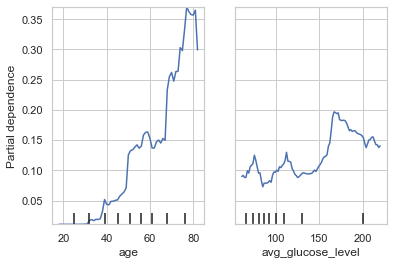

In [93]:
PartialDependenceDisplay.from_estimator(cv_rf, X_train, ['age','avg_glucose_level'])

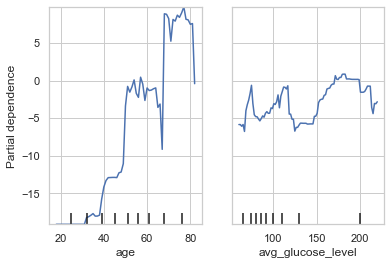

In [94]:
PartialDependenceDisplay.from_estimator(cv_gb, X_train, ['age','avg_glucose_level'])